In [2]:
import re
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob

# Evaluation of pyAscore performance on the Marx Synthetic Peptides

## 1) Intro

In order to test pyAscore with known peptide sequences, we will be looking at a synthetic peptide set developed by Marx *et al.* (2013). This has been measured multiple times -- high resolution HCD and ETD in PXD000138 and low resolution CID in PXD000759. These datasets provide a great test bed due to the large amount of spectra. We searched both datasets with the recommended parameters for the individual instrument setups. Then, we used multiple pyAscore parameters on the dataset to determine if the algorithm could be effectively tailored to the instrument parameters.

Here, we will first look at the total number of PSMs which correspond to the original peptide library built in Marx *et al.*. Once we have this set of peptide, we will build a comparison plot of the FLRs between parameter choices.

## 2) Load PSM data and evaluate number of correct matches

After taking a glance at the literature, it appears that most papers treat each individual PSM as a independent sample for calculating false localization rate. Thus, we will also focus on PSMs here but we will try to give an overview of underlying sequence effects at some point. Given that these are sythetic peptide runs, we know exactly which peptides should be where. Thus, to be stringent, we will only evaluate the counts of PSMs which pass a 1% global peptide FDR threshold, have a single phosphorylation, and which occur in their correct sample.

### 2.1) Load seed peptide data

Here we load and prepare the list of seed peptides sequences. Since the detected peptides will be derived from these, it is important to make the sequences into a propper regex which can validate that a matched peptide definitely came from the library.

In [3]:
seed_peptides = pd.read_csv("../aux/PXD000138_seed_peptides.csv")[["Library", "Seed Peptide Sequence",
                                                                   "Phosphosite Position", "Length"]]
seed_peptides.columns = ["library", "seedSequence", "truePos", "trueLength"]
seed_peptides["validationRegex"] = seed_peptides.seedSequence.str.replace("[A-Z]?p[STY][A-Z]?", 
                                                                          "[A-Z]?[STY][A-Z]?", 
                                                                           regex=True)

### 2.2) Load PSMs

In [4]:
# In the FASTA file, the batch is labeled with letters and two numbers
# which codes batches 1-96 as 8 batches of 12.
def determine_batch(query):
    letter_to_number = {l : ind for ind, l in enumerate("ABCDEFGH")}
    query = query.split(":")[1]
    return 12*letter_to_number[query[0]] + int(query[1:])

#### 2.2.1) PXD000138-HCD

In [6]:
# 1. Load data and filter for high confidence PSMs
hcd_psms = pd.read_csv("../results/search/PXD000138-HCD/mokapot.psms.txt", sep="\t")
hcd_psms["Dataset"] = "High Res. HCD"
hcd_psms["Peptide"] = hcd_psms["Peptide"].str.replace("^.\.", "", regex=True)\
                                         .str.replace("\..$", "", regex=True)
hcd_psms = hcd_psms[hcd_psms["mokapot q-value"] < 0.01]

# 2. Validate peptide detections using seed peptides
hcd_psms["Library"] = hcd_psms["SpecId"].str.replace("_.*", "", regex=True).astype(int)
hcd_psms = hcd_psms.join(seed_peptides.set_index("library")["validationRegex"],
                         on="Library")
at_most_one_phospho = hcd_psms["Peptide"].str.count("79") <= 1
from_seed = hcd_psms.apply(lambda s: re.match(s["validationRegex"], 
                                              re.sub("[^A-Z]", "", s["Peptide"])) is not None,
                           axis=1)
hcd_psms = hcd_psms[np.logical_and(at_most_one_phospho, from_seed)]

# 3. Retain relevant columns
hcd_psms = hcd_psms[["Dataset", "SpecId", "ScanNr", "Peptide", "Library"]]

#### 2.2.2) PXD000138-ETD

In [7]:
# 1. Load data and filter for high confidence PSMs
etd_psms = pd.read_csv("../results/search/PXD000138-ETD/mokapot.psms.txt", sep="\t")
etd_psms["Dataset"] = "High Res. ETD"
etd_psms["Peptide"] = etd_psms["Peptide"].str.replace("^.\.", "", regex=True)\
                                         .str.replace("\..$", "", regex=True)
etd_psms = etd_psms[etd_psms["mokapot q-value"] < 0.01]

# 2. Validate peptide detections using seed peptides
etd_psms["Library"] = etd_psms["SpecId"].str.extract("(?<=run)([0-9]+)").astype(int)
etd_psms = etd_psms.join(seed_peptides.set_index("library")["validationRegex"],
                         on="Library")
at_most_one_phospho = etd_psms["Peptide"].str.count("79") <= 1
from_seed = etd_psms.apply(lambda s: re.match(s["validationRegex"], 
                                              re.sub("[^A-Z]", "", s["Peptide"])) is not None,
                           axis=1)
etd_psms = etd_psms[np.logical_and(at_most_one_phospho, from_seed)]

# 3. Retain relevant columns
etd_psms = etd_psms[["Dataset", "SpecId", "ScanNr", "Peptide", "Library"]]

#### 2.2.3) PXD000759

In [8]:
# 1. Load data and filter for high confidence PSMs
cid_psms = pd.read_csv("../results/search/PXD000759/mokapot.psms.txt", sep="\t")
cid_psms["Dataset"] = "High Res. CID"
cid_psms["Peptide"] = cid_psms["Peptide"].str.replace("^.\.", "", regex=True)\
                                         .str.replace("\..$", "", regex=True)
cid_psms = cid_psms[cid_psms["mokapot q-value"] < 0.01]

# 2. Validate peptide detections using seed peptides
cid_psms["Library"] = cid_psms["SpecId"].str.replace("_.*", "", regex=True)\
                                        .str.replace("lib", "").astype(int)
cid_psms = cid_psms.join(seed_peptides.set_index("library")["validationRegex"],
                         on="Library")
at_most_one_phospho = cid_psms["Peptide"].str.count("79") <= 1
from_seed = cid_psms.apply(lambda s: re.match(s["validationRegex"], 
                                              re.sub("[^A-Z]", "", s["Peptide"])) is not None,
                           axis=1)
cid_psms = cid_psms[np.logical_and(at_most_one_phospho, from_seed)]

# 3. Retain relevant columns
cid_psms = cid_psms[["Dataset", "SpecId", "ScanNr", "Peptide", "Library"]]

### 2.3) Total detections

In [9]:
hcd_psm_counts = hcd_psms.groupby(["Dataset", "Library"])\
                         .apply(lambda df: pd.Series({"Total" : df.shape[0],
                                                      "Phospho" : df["Peptide"].str.contains("79").sum()}))\
                         .reset_index()

etd_psm_counts = etd_psms.groupby(["Dataset", "Library"])\
                         .apply(lambda df: pd.Series({"Total" : df.shape[0],
                                                      "Phospho" : df["Peptide"].str.contains("79").sum()}))\
                         .reset_index()

cid_psm_counts = cid_psms.groupby(["Dataset", "Library"])\
                         .apply(lambda df: pd.Series({"Total" : df.shape[0],
                                                      "Phospho" : df["Peptide"].str.contains("79").sum()}))\
                         .reset_index()

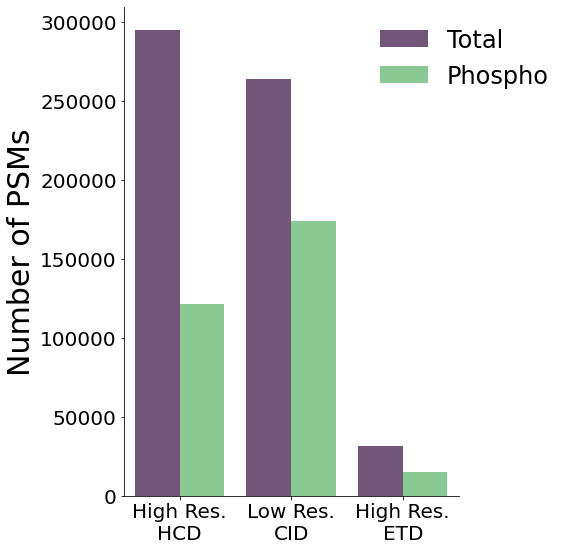

In [10]:
fig = plt.figure(figsize=[6, 9])

sns.barplot(data=pd.concat([
                     hcd_psm_counts,
                     cid_psm_counts,
                     etd_psm_counts
                 ]).melt(id_vars=["Dataset", "Library"],
                         var_name="Subset",
                         value_name="PSMs"),
            x="Dataset",
            y="PSMs",
            hue="Subset",
            estimator=sum,
            ci=None,
            palette=["#461554", "#56c566"],
            alpha=.75)

plt.xticks(range(3), ["High Res.\nHCD", "Low Res.\nCID", "High Res.\nETD"])
plt.xlabel("")
plt.ylabel("Number of PSMs",
           size=30)

#plt.ylim(0, 210000)
plt.tick_params(labelsize=20)
plt.legend(fontsize=24,
           frameon=False,
           bbox_to_anchor=(.7, 1))
sns.despine()
plt.savefig("figures/marx_synthetic_peptide_detections.svg",
            bbox_inches="tight",
            facecolor="white")
plt.show()

The HCD and CID datasets have about the same number of total PSMs but the second dataset seems to have more singly phosphorylated PSMs. The sample series that we downloaded for the Low Res. CID dataset was labeled as not being phophoenriched, but it is possible something else is increasing the total amount of phospho-PSMs in the datasets. Sadly, it appears that the ETD dataset has a very low number of detections. While this is likely enough to evaluate false localization rate, the amount data passing a given Ascore threshold may be quite low.

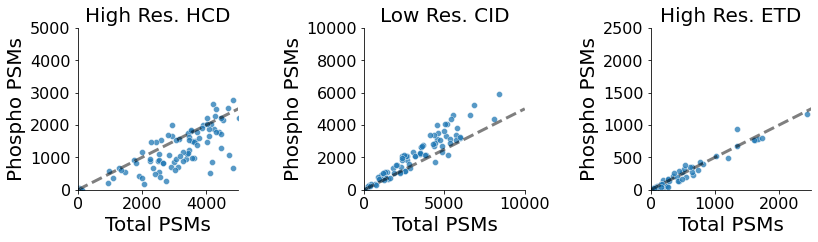

In [11]:
fig, axes = plt.subplots(figsize=[12, 4], ncols=3)

# PXD000138-HCD
sns.scatterplot(data=hcd_psm_counts,
                x="Total",
                y="Phospho",
                palette=["#30708d"],
                lw=0,
                alpha=.75,
                ax=axes[0])
axes[0].set_title("High Res. HCD", size=20)
axes[0].set_xlim(0, 5000)
axes[0].set_ylim(0, 5000)

# PXD000759
sns.scatterplot(data=cid_psm_counts,
                x="Total",
                y="Phospho",
                palette=["#30708d"],
                lw=0,
                alpha=.75,
                ax=axes[1])
axes[1].set_title("Low Res. CID", size=20)
axes[1].set_xlim(0, 10000)
axes[1].set_ylim(0, 10000)

# PXD000138-ETD
sns.scatterplot(data=etd_psm_counts,
                x="Total",
                y="Phospho",
                palette=["#30708d"],
                lw=0,
                alpha=.75,
                ax=axes[2])
axes[2].set_title("High Res. ETD", size=20)
axes[2].set_xlim(0, 2500)
axes[2].set_ylim(0, 2500)

# Common features
for ax in axes:
    ax.plot([0, 10000],
            [0, 5000],
            c="black",
            lw=3,
            alpha=.5,
            linestyle="--")
    ax.tick_params(labelsize=16)
    ax.set_xlabel("Total PSMs", size=20)
    ax.set_ylabel("Phospho PSMs", size=20)

fig.tight_layout(pad=3.0)
sns.despine()
plt.savefig("figures/marx_synthetic_peptide_phospho_vs_total.svg",
            bbox_inches="tight",
            facecolor="white")
plt.show()

The above plots give a look at numbers of phospho-PSMs vs total psms at the run level. Theoretically, according to the description of how the data was built, phosphorylated peptides should make up about half the total peptides in the sample (thus the y=x/2 line). Samples in the CID dataset do seem to be consistently high quality in their number of phospho-PSMs, with the slight enrichment for phosphorylation apparent. 

## 3) Load pyAscore data and evaluated False Localization Rates

For each dataset, we evaluated 2 different parameter settings -- one where the MS2 error for peaks was set at +-0.5 (wide) and one where it was set at +-0.05. The hypothesis is that tailoring the MS2 error to the instrument parameters will greatly increase the performance of the algorithm.

### 3.1) Load Ascores and match to PSMs

In [12]:
def find_mod(seq):
    for ind, aa in enumerate(re.finditer("[A-Z][^A-Z]*", seq)):
        if aa.group() in ["S[80]", "T[80]", "Y[80]"]:
            return ind + 1
        
def calculate_flr(score_array, success_array):
    nclassifications = np.arange(1, success_array.shape[0] + 1)
    nfailures = np.cumsum(~success_array)
    flr = nfailures/nclassifications
    return flr
    for ind in np.arange(flr.shape[0])[::-1]:
        if ind - 1 >= 0 and score_array[ind] == score_array[ind-1]:
            flr[ind - 1] = flr[ind]
    
        if ind + 1 < flr.shape[0]:
            flr[ind] = min(flr[ind], flr[ind + 1])
    
    return flr

def read_pyascore_file(f):
    data = pd.read_csv(f, sep="\t")
    library = re.search("((^)|(run)|(lib))[0-9]+", os.path.basename(f).split(".")[0]).group()
    data["Library"] = int(re.sub("[^0-9]", "", library))
    return data

def read_pyascore(glob_string, psms):
    # Load data and match to PSMs
    ascores = pd.concat([read_pyascore_file(f) for f in glob(glob_string)])
    ascores = psms[["Library", "ScanNr"]].join(ascores.set_index(["Library", "Scan"]),
                                               on=["Library", "ScanNr"],
                                               how="inner")
    
    # Find mods, fix ascores, and filter out non-ambiguous peptides
    ascores["modPos"] = ascores["LocalizedSequence"].apply(find_mod)
    ascores = ascores.join(seed_peptides.set_index("library").truePos,
                           on = "Library")
    ascores["Ascores"] = ascores["Ascores"].astype(float)
    ascores = ascores[~np.isinf(ascores["PepScore"])]\
                     .sort_values("Ascores", ascending=False)
    
    # Calculate final FLR
    success = ascores["modPos"].values == ascores["truePos"].values
    ascores["FLR"] = calculate_flr(ascores["Ascores"].values, success)
    ascores["Proportion"] = np.arange(1, ascores.shape[0]+1)/ascores.shape[0]
    
    return ascores

In [13]:
hcd_wide_pyascore = read_pyascore("../results/localization/PXD000138-HCD/*pyascore.wide.txt", hcd_psms)
hcd_wide_pyascore["Dataset"] = "High Res. HCD"
hcd_wide_pyascore["Parameters"] = "Wide MS2 Tol."

hcd_narrow_pyascore = read_pyascore("../results/localization/PXD000138-HCD/*pyascore.narrow.txt", hcd_psms)
hcd_narrow_pyascore["Dataset"] = "High Res. HCD"
hcd_narrow_pyascore["Parameters"] = "Narrow MS2 Tol."

In [14]:
etd_wide_pyascore = read_pyascore("../results/localization/PXD000138-ETD/*pyascore.wide.txt", etd_psms)
etd_wide_pyascore["Dataset"] = "High Res. ETD"
etd_wide_pyascore["Parameters"] = "Wide MS2 Tol."

etd_narrow_pyascore = read_pyascore("../results/localization/PXD000138-ETD/*pyascore.narrow.txt", etd_psms)
etd_narrow_pyascore["Dataset"] = "High Res. ETD"
etd_narrow_pyascore["Parameters"] = "Narrow MS2 Tol."

In [15]:
cid_wide_pyascore = read_pyascore("../results/localization/PXD000759/*pyascore.wide.txt", cid_psms)
cid_wide_pyascore["Dataset"] = "Low Res. CID"
cid_wide_pyascore["Parameters"] = "Wide MS2 Tol."

cid_narrow_pyascore = read_pyascore("../results/localization/PXD000759/*pyascore.narrow.txt", cid_psms)
cid_narrow_pyascore["Dataset"] = "Low Res. CID"
cid_narrow_pyascore["Parameters"] = "Narrow MS2 Tol."

### 3.2) Comparing false localization rates

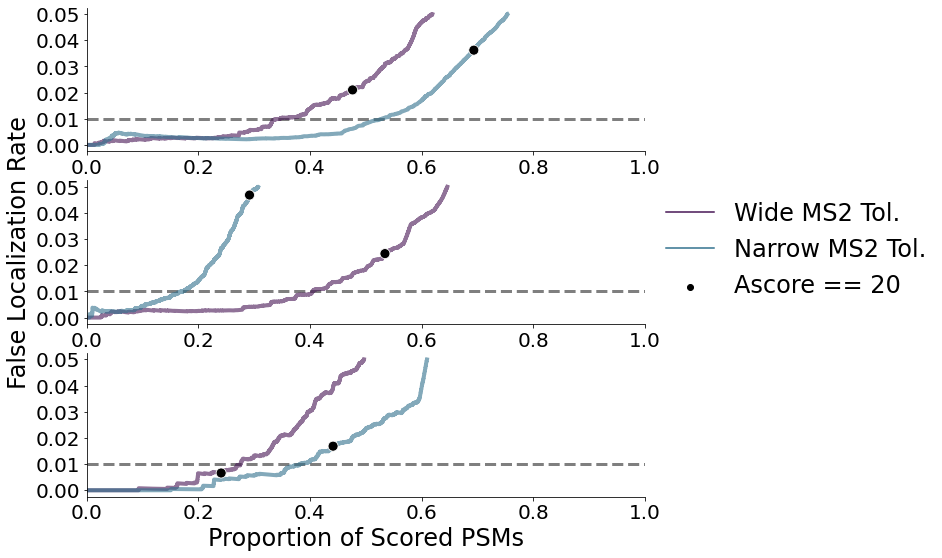

In [16]:
fig, axes = plt.subplots(nrows=3, figsize=[10, 9])

def build_lineplot(df, ax):
    ax.plot([0, 1],
            [0.01, 0.01],
            linestyle="--",
            c="black",
            lw=3,
            alpha=.5,
            zorder=0)
    
    sns.lineplot(data=df[df.FLR < 0.05],
                 x="Proportion",
                 y="FLR",
                 hue="Parameters",
                 palette=["#461554", "#30708d"],
                 alpha=.6,
                 lw=4,
                 ax=ax)
    
    sns.scatterplot(data = df[df.Ascores >= 20]\
                             .groupby(["Dataset", "Parameters"])[["FLR", "Proportion"]]\
                             .last()\
                             .reset_index(),
                    x="Proportion",
                    y="FLR",
                    hue=["Ascore == 20"]*2,
                    palette=["black"],
                    s=100,
                    zorder=100,
                    label=None,
                    ax=ax)

build_lineplot(pd.concat([hcd_wide_pyascore, hcd_narrow_pyascore], 
                         ignore_index=True),
               ax=axes[0])

build_lineplot(pd.concat([cid_wide_pyascore, cid_narrow_pyascore], 
                         ignore_index=True),
               ax=axes[1])

build_lineplot(pd.concat([etd_wide_pyascore, etd_narrow_pyascore], 
                         ignore_index=True),
               ax=axes[2])

for ax in axes:
    ax.set_xlim(0, 1)
    ax.tick_params(labelsize=20)
    ax.set_yticks([0.00, 0.01, 0.02, 0.03, 0.04, 0.05])
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.get_legend().remove()
    
axes[2].set_xlabel("Proportion of Scored PSMs",
                   size=24)
axes[1].set_ylabel("False Localization Rate",
                   size=24)
axes[1].legend(fontsize=24,
               frameon=False,
               bbox_to_anchor=(1, 1))
sns.despine()
plt.savefig("figures/marx_synthetic_peptide_flr_by_cutoff.svg",
            bbox_inches="tight",
            facecolor="white")
plt.show()

The above plot gives direct confirmation of our initial hypothesis. Using the wide peak tolerance for low resolution data greatly increased performance, and the narrow peak tolerance improved results for the high resolution data. This strongly suggests that tailoring the algorithm to instrument parameters is the best way to go. While it is difficult to compare datasets, due to differences in detections, we do want to note that most of the poor performance in the case of the ETD dataset is likely coming from the low number of dections and not poor algorithmic performance.

In [17]:
ascore_matched_data = pd.concat([hcd_narrow_pyascore,
                                 cid_wide_pyascore,
                                 etd_narrow_pyascore])

ascore_notmatched_data = pd.concat([hcd_wide_pyascore,
                                    cid_narrow_pyascore,
                                    etd_wide_pyascore])

ascore_data = pd.concat([ascore_matched_data, ascore_notmatched_data])

In [18]:
ascore_counts = ascore_matched_data.groupby(["Dataset", "Parameters"], sort=False)\
                                   .apply(lambda df: pd.DataFrame({"Cutoff" : ["FLR $\leq$ 0.01", 
                                                                               "Ascore $\geq$ 20",
                                                                               "Scorable"],
                                                                   "Count" : [np.sum(df.FLR <= 0.01),
                                                                              np.sum(df.Ascores >= 20),
                                                                              df.shape[0]]}))\
                                   .reset_index()

ascore_counts["xLabel"] = ascore_counts["Dataset"] + "\n" + ascore_counts["Parameters"]

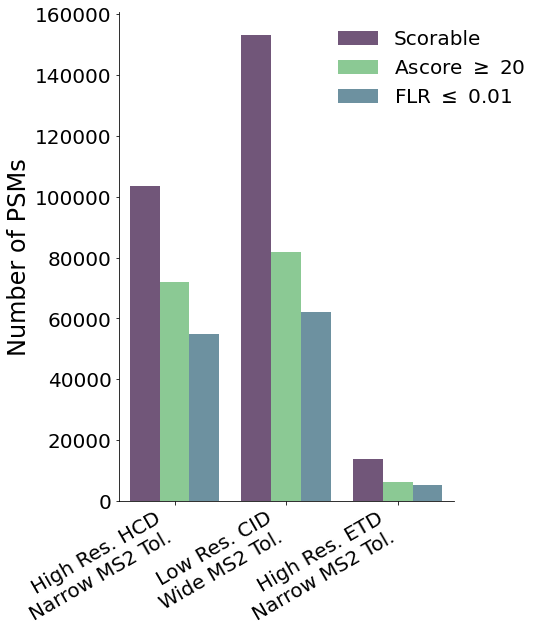

In [19]:
fig = plt.figure(figsize=[6, 9])

sns.barplot(data = ascore_counts,
            x="xLabel",
            y="Count",
            hue="Cutoff",
            hue_order=["FLR $\leq$ 0.01", "Ascore $\geq$ 20", "Scorable"][::-1],
            palette=["#461554", "#56c566", "#30708d"],
            alpha=.75)

plt.xlabel("")
plt.ylabel("Number of PSMs",
           size=24)
plt.tick_params(labelsize=20)
plt.xticks(rotation=30,
           ha="right")
plt.legend(fontsize=20,
           frameon=False,
           bbox_to_anchor=(.6, 1))
sns.despine()
plt.savefig("figures/marx_synthetic_peptide_flr_barplot.svg",
            bbox_inches="tight",
            facecolor="white")
plt.show()

The part about the above plot that we find very ecouraging is just how close we get to a 1% FLR with an Ascore of 20. This was the value used in the original Ascore paper and it is good to see that we can continue to recommend it going forward.